# Parallel Coordinates plot
Seeing if it's possible to replace the comparison scatterplot with a parallel coordinates plot

In [1]:
%load_ext autoreload
%autoreload 2

In [67]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

In [69]:
from src.data.utils import DATA_DIR
from src.visualization.utils import palette, get_palette

In [4]:
df = pd.read_csv(f'{DATA_DIR}/processed/GBD_child_health_indicators.csv')
location_metadata = pd.read_csv(f'{DATA_DIR}/metadata/gbd_location_metadata.csv')
indicators = list(df.indicator.unique())
n_neighbors = 4
year_ids = list(df.year_id.unique())

# Indicator Value by country in wide format
index_vars = ['location_name', 'year_id']
df_wide = df.pivot_table(index=index_vars, columns='indicator', values='val').reset_index()
df_wide = pd.merge(location_metadata, df_wide)
df_wide.head()

,location_id,ihme_loc_id,location_name,level,year_id,Ambient air pollution,Child stunting,Child underweight,Child wasting,Congenital birth defects,...,Secondhand smoke,Short gestation for birth weight,Sudden infant death syndrome,Tuberculosis,Under-5 Mortality Rate,Unsafe sanitation,Unsafe water source,Vitamin A deficiency,Whooping cough,Zinc deficiency
0,33,ARM,Armenia,3,1990,36.26,21.73,4.75,4.76,40.29,...,100.00,22.57,7.59,3.99,17.49,47.50,9.67,0.0,0.01,45.29
1,33,ARM,Armenia,3,1995,36.12,22.16,4.38,4.95,32.08,...,99.34,15.98,4.96,1.63,13.03,42.52,9.45,0.0,0.01,62.24
2,33,ARM,Armenia,3,2000,41.40,23.50,3.74,6.10,35.42,...,97.98,22.14,4.72,1.80,10.00,35.73,8.83,0.0,0.00,43.35
3,33,ARM,Armenia,3,2005,47.81,23.20,3.06,8.18,25.88,...,98.93,34.28,4.91,1.43,6.32,27.87,6.35,0.0,0.01,15.65
4,33,ARM,Armenia,3,2010,55.11,20.62,2.43,8.81,19.49,...,99.12,33.06,3.96,0.85,4.25,20.95,4.20,0.0,0.02,7.92


In [10]:
location_name = 'Nigeria'
countries = []
comparison_type = 'Countries'
year = 2017
data = df_wide.query(f'year_id == {year}')[['location_name'] + indicators].set_index('location_name')
l_data = data.loc[location_name]
similarity = np.abs(data ** 2 - l_data ** 2).sum(axis=1).sort_values()
locs = similarity[:n_neighbors + 1].index.tolist()
if countries is not None:
    locs += countries
df_similar = data.loc[locs]
if comparison_type == 'Value':
    title = f'Indicators of {location_name} and similar countries'
elif comparison_type == 'Comparison':
    df_similar = (df_similar - l_data)
    title = f'Indicators of countries relative to {location_name}'
df_similar = df_similar.reset_index().melt(id_vars='location_name', var_name='indicator')
df_similar.sort_values(['location_name', 'indicator'], ascending=[True, False], inplace=True)
df_similar['size'] = 10
df_similar.loc[df_similar.location_name == location_name, 'size'] = 14
df_similar.head()

,location_name,indicator,value,size
161,Angola,Zinc deficiency,18.16,10
156,Angola,Whooping cough,25.97,10
151,Angola,Vitamin A deficiency,53.70,10
146,Angola,Unsafe water source,88.42,10
141,Angola,Unsafe sanitation,61.30,10


In [11]:
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# Connect Javascript to display the plots in the notebook
init_notebook_mode(connected=True)

### Existing Plot
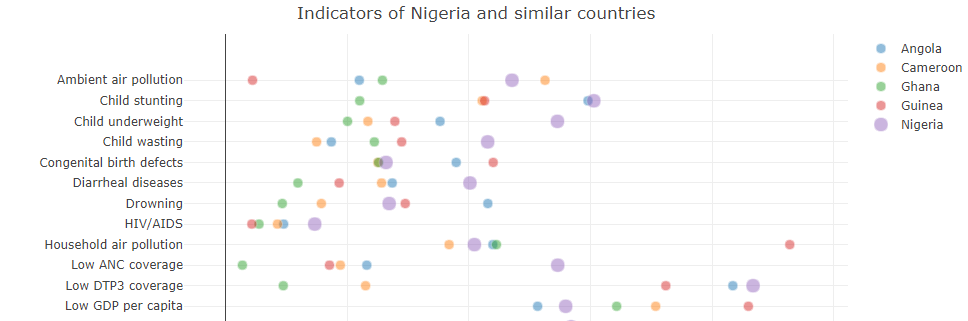

In [19]:
plot = [go.Scatter(
            x=df_similar[df_similar['location_name'] == i]['value'],
            y=df_similar[df_similar['location_name'] == i]['indicator'],
            text=str(i),
            mode='markers',
            opacity=0.7,
            marker={
                'size': df_similar[df_similar['location_name'] == i]['size'],
                'line': {'width': 0.5, 'color': 'white'}
            },
            name=str(i)
        ) for i in df_similar.location_name.unique()]

iplot({
        'data': plot,
        'layout': go.Layout(
            title=f'Indicators of {location_name} and similar countries',
            height=150 + 20 * len(indicators),
            margin={'l': 200, 'b': 30, 't': 30, 'r': 0},
            hovermode='closest'
        )})

In [27]:
df[df.indicator == 'Tuberculosis']['value']

131    18.67
132    13.55
134     5.65
133    33.81
130    36.07
Name: value, dtype: float64

### Parallel coordinates plot

In [49]:
df.indicator.unique().tolist().remove('Under-5 Mortality Rate')

In [50]:
df.indicator.unique().tolist()

['Zinc deficiency',
 'Whooping cough',
 'Vitamin A deficiency',
 'Unsafe water source',
 'Unsafe sanitation',
 'Under-5 Mortality Rate',
 'Tuberculosis',
 'Sudden infant death syndrome',
 'Short gestation for birth weight',
 'Secondhand smoke',
 'STDs excluding HIV',
 'Road injuries',
 'Protein-energy malnutrition',
 'Non-exclusive breastfeeding',
 'No access to handwashing facility',
 'Neonatal disorders',
 'Meningitis',
 'Measles',
 'Malaria',
 'Lower respiratory infections',
 'Low birth weight for gestation',
 'Low GDP per capita',
 'Low DTP3 coverage',
 'Low ANC coverage',
 'Household air pollution',
 'HIV/AIDS',
 'Drowning',
 'Diarrheal diseases',
 'Congenital birth defects',
 'Child wasting',
 'Child underweight',
 'Child stunting',
 'Ambient air pollution']

In [59]:
from src.visualization.utils import palette

In [63]:
#colorscale = [[0,'#D7C16B'],[0.5,'#23D8C3'],[1,'#F3F10F']]
df = df_similar.copy()
df['cluster'] = np.random.randint(0, 5, len(df)) # HACK - initialize clusters
colorscale = 
data = [
    go.Parcoords(
        line = dict(color = df['cluster'], colorscale=palette), #colorscale = [['Nigeria','#D7C16B']], showscale = True
        dimensions = list(
            [dict(
                range = [0,100], constraintrange = [0,100],
                label = 'U5MR', values = df[df.indicator == 'Under-5 Mortality Rate']['value'])] + 
            [dict(
                range = [0,100],
                label = i, values = df[df.indicator == i]['value'])
        for i in df.indicator.unique()]
        )
    )]

layout = go.Layout(
    plot_bgcolor = '#E5E5E5',
    paper_bgcolor = '#E5E5E5'
)

iplot(data, layout)

In [64]:
def cluster_kmeans(n_clusters, indicators, year):
    df_c = df_wide.query(f'year_id == {year}')[['location_name'] + indicators].set_index('location_name')
    kmean = KMeans(n_clusters=n_clusters, random_state=0)
    kmean.fit(df_c)

    # Get U5MR by cluster and map cluster number to rank
    df_ordered = df_wide.query(f'year_id == {year}')
    df_ordered['cluster'] = kmean.labels_
    df_ordered = df_ordered.groupby('cluster')['Under-5 Mortality Rate'].mean().reset_index()
    df_ordered['U5MR_rank'] = df_ordered['Under-5 Mortality Rate'].rank().astype(
        'int') - 1  # rank starts at 1, we want 0-indexed
    cluster_map = df_ordered.set_index('cluster')['U5MR_rank'].to_dict()

    # Set cluster equal to U5MR rank
    df_c.reset_index(inplace=True)
    df_c['cluster'] = pd.Series(kmean.labels_).map(cluster_map)
    df_c = pd.merge(location_metadata, df_c)
    df_c['color'] = df_c.cluster.map(get_palette(n_clusters))
    return df_c.to_json()

In [73]:
indicators = df.indicator.unique().tolist()
df_c = pd.read_json(cluster_kmeans(5, indicators, 2017))
df_c.head()

c:\users\zrankin\appdata\local\continuum\miniconda3\envs\health_indicators\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



,location_id,ihme_loc_id,location_name,level,Zinc deficiency,Whooping cough,Vitamin A deficiency,Unsafe water source,Unsafe sanitation,Under-5 Mortality Rate,...,HIV/AIDS,Drowning,Diarrheal diseases,Congenital birth defects,Child wasting,Child underweight,Child stunting,Ambient air pollution,cluster,color
0,33,ARM,Armenia,3,5.61,0.02,0.00,3.27,23.96,2.35,...,0.21,1.34,0.33,11.16,9.52,1.64,13.08,52.06,0,#0000ff
1,34,AZE,Azerbaijan,3,8.27,6.53,25.64,11.52,40.54,13.78,...,0.06,6.06,2.49,30.24,12.59,4.96,17.43,31.27,0,#0000ff
10,40,TKM,Turkmenistan,3,6.72,0.33,24.58,21.80,47.54,9.66,...,0.14,10.10,1.37,26.74,7.26,2.37,12.29,41.22,0,#0000ff
100,140,BHR,Bahrain,3,4.59,0.73,18.95,15.23,6.57,1.36,...,0.17,0.87,0.07,9.70,6.22,7.04,4.89,100.00,1,#00bfff
101,141,EGY,Egypt,3,7.93,3.71,17.62,9.90,25.41,6.58,...,0.01,1.31,7.24,21.76,18.37,5.62,22.26,100.00,1,#00bfff


In [88]:
df_c.cluster.unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [97]:
n_clusters = len(df_c.cluster.unique())
colorscale = list(zip(palette.keys(), [palette[k] for k in palette.keys()]))
colorscale = [[0,'#0000ff'],[1,'#00bfff'],[2,'#00ffbf'], [3,'#40ff00'],[4,'#f2f20d']]
colorscale = [[k / (n_clusters - 1), get_palette(n_clusters)[k]] for k in
                  range(0, n_clusters)]  # choropleth colorscale seems to need 0-1 range
colorscale

[[0.0, '#0000ff'],
 [0.25, '#00bfff'],
 [0.5, '#f2f20d'],
 [0.75, '#ff8000'],
 [1.0, '#ff0000']]

In [154]:
data = [
    go.Parcoords(
        # test=None,
        line = dict(color = df_c['cluster'], colorscale=colorscale), #colorscale = [['Nigeria','#D7C16B']], showscale = True
        # opacity=0.1,
        # name=['test'] + indicators,
        # hoverinfo='test',
        dimensions = list(
            [dict(
                range = [0,100], constraintrange = [0,100],
                label = 'U5MR', values = df_c['Under-5 Mortality Rate'])] + 
            [dict(
                range = [0,100],
                tickvals=[100],
                tickformat=dict(visible=True, tickangle=180),
                label = i, 
                values = df_c[i])
        for i in indicators]
        )
    )]

# layout = go.Layout(
#     xaxis = dict(visible=False, range=(0,10), title='TEST')
# )

layout = go.Layout(
    autosize=False,
    # width=1600,
    height=80,
    plot_bgcolor = '#E5E5E5',
    paper_bgcolor = '#E5E5E5',

    title='Charity Comparison Plot'
)

iplot(data, layout)

In [95]:
df.species_id.unique()

array([1, 2, 3], dtype=int64)

In [94]:
df = pd.read_csv("https://raw.githubusercontent.com/bcdunbar/datasets/master/iris.csv")

data = [
    go.Parcoords(
        line = dict(color = df['species_id'],
                   colorscale = [[0,'#D7C16B'],[0.5,'#23D8C3'],[1,'#F3F10F']]),
        dimensions = list([
            dict(range = [0,8],
                constraintrange = [4,8],
                label = 'Sepal Length', values = df['sepal_length']),
            dict(range = [0,8],
                label = 'Sepal Width', values = df['sepal_width']),
            dict(range = [0,8],
                label = 'Petal Length', values = df['petal_length']),
            dict(range = [0,8],
                label = 'Petal Width', values = df['petal_width'])
        ])
    )
]

layout = go.Layout(
    plot_bgcolor = '#E5E5E5',
    paper_bgcolor = '#E5E5E5'
)

iplot(data, layout)

In [20]:
data = [
    go.Parcoords(
        line = dict(color = 'blue'),
        dimensions = list([
            dict(range = [1,5],
                 constraintrange = [1,2],
                 label = 'A', values = [1,4]),
            dict(range = [1.5,5],
                 tickvals = [1.5,3,4.5],
                 label = 'B', values = [3,1.5]),
            dict(range = [1,5],
                 tickvals = [1,2,4,5],
                 label = 'C', values = [2,4],
                 ticktext = ['text 1', 'text 2', 'text 3', 'text 4']),
            dict(range = [1,5],
                 label = 'D', values = [4,2])
        ])
    )
]

iplot(data)